In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mu7annad.0gmail.com/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
arabic_stopwords = set(stopwords.words('arabic'))
arabic_stopwords

{'ء',
 'ءَ',
 'آ',
 'آب',
 'آذار',
 'آض',
 'آمينَ',
 'آناء',
 'آنفا',
 'آه',
 'آها',
 'آهاً',
 'آهٍ',
 'آهِ',
 'آي',
 'أ',
 'أبدا',
 'أبريل',
 'أبو',
 'أبٌ',
 'أجل',
 'أجمع',
 'أحد',
 'أخبر',
 'أخذ',
 'أخو',
 'أخٌ',
 'أربع',
 'أربعاء',
 'أربعة',
 'أربعمئة',
 'أربعمائة',
 'أرى',
 'أسكن',
 'أصبح',
 'أصلا',
 'أضحى',
 'أطعم',
 'أعطى',
 'أعلم',
 'أغسطس',
 'أف',
 'أفريل',
 'أفعل به',
 'أفٍّ',
 'أقبل',
 'أقل',
 'أكتوبر',
 'أكثر',
 'أل',
 'ألا',
 'ألف',
 'ألفى',
 'أم',
 'أما',
 'أمام',
 'أمامك',
 'أمامكَ',
 'أمد',
 'أمس',
 'أمسى',
 'أمّا',
 'أن',
 'أنا',
 'أنبأ',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'أنتِ',
 'أنشأ',
 'أنى',
 'أنًّ',
 'أنّى',
 'أهلا',
 'أو',
 'أوت',
 'أوشك',
 'أول',
 'أولئك',
 'أولاء',
 'أولالك',
 'أوه',
 'أوّهْ',
 'أى',
 'أي',
 'أيا',
 'أيار',
 'أيضا',
 'أيلول',
 'أين',
 'أينما',
 'أيها',
 'أيّ',
 'أيّان',
 'أُفٍّ',
 'ؤ',
 'إحدى',
 'إذ',
 'إذا',
 'إذاً',
 'إذما',
 'إذن',
 'إزاء',
 'إلا',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'إليكنّ',
 'إليكَ',
 'إلَيْكَ',
 'إلّا',


In [4]:
ar_stopwords = set(stopwords.words('arabic'))

def process_text(text):
    stemmer = nltk.ISRIStemmer()
    word_list = nltk.word_tokenize(text)
    # remove Arabic stopwords
    word_list = [w for w in word_list if w not in ar_stopwords]
    # remove digits
    word_list = [w for w in word_list if not w.isdigit()]
    # stemming
    word_list = [stemmer.stem(w) for w in word_list]
    return ' '.join(word_list)

def clean_text(text):
    search = ["أ", "إ", "آ", "ة", "_", "-", "/", ".", "،", " و ", " يا ", '"', "ـ", "'", "ى",
              "\\", '\n', '\t', '"', '?', '؟', '!']
    replace = ["ا", "ا", "ا", "ه", " ", " ", "", "", "", " و", " يا",
               "", "", "", "ي", "", ' ', ' ', ' ', ' ? ', ' ؟ ', ' ! ']

    # remove tashkeel
    tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(tashkeel, "", text)

    # normalize elongation
    longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(longation, subst, text)

    text = re.sub(r"[^\w\s]", '', text)             # remove punctuation
    text = re.sub(r"[a-zA-Z]", '', text)            # remove English letters
    text = re.sub(r"\d+", ' ', text)                # remove digits
    text = re.sub(r"\n+", ' ', text)                # remove newlines
    text = re.sub(r"\t+", ' ', text)                # remove tabs
    text = re.sub(r"\r+", ' ', text)                # remove carriage returns
    text = re.sub(r"\s+", ' ', text)                # normalize spaces

    # remove specific character repetitions
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(len(search)):
        text = text.replace(search[i], replace[i])

    text = text.strip()

    return process_text(text)

def load_file(path):
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = ["label", "text"]
    df['label'] = df['label'].map({'pos': 1, 'neg': 0})
    df['text'] = df['text'].astype(str).apply(clean_text)
    return df

In [5]:
# Load and preprocess
train_pos = load_file("/content/drive/MyDrive/we_sentiment/Sentiment Analysis/train_Arabic_tweets_positive_20190413.tsv")
train_neg = load_file("/content/drive/MyDrive/we_sentiment/Sentiment Analysis/train_Arabic_tweets_negative_20190413.tsv")
test_pos = load_file("/content/drive/MyDrive/we_sentiment/Sentiment Analysis/test_Arabic_tweets_positive_20190413.tsv")
test_neg = load_file("/content/drive/MyDrive/we_sentiment/Sentiment Analysis/test_Arabic_tweets_negative_20190413.tsv")

# Combine within each split
train_df = pd.concat([train_pos, train_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([test_pos, test_neg], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-6-a8e18f09e321>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='Set1')


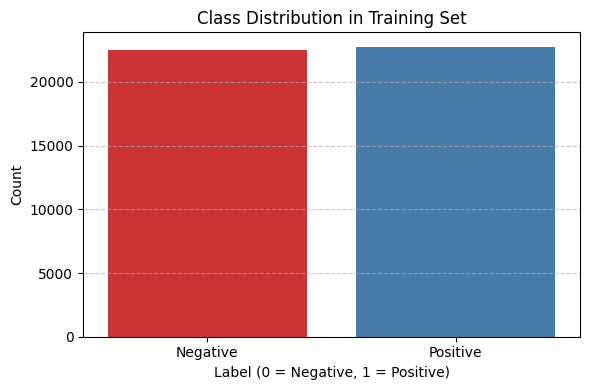

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution for training data
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='Set1')
plt.title('Class Distribution in Training Set')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-7-6637dd1e6cb2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_df, x='label', palette='Set1')


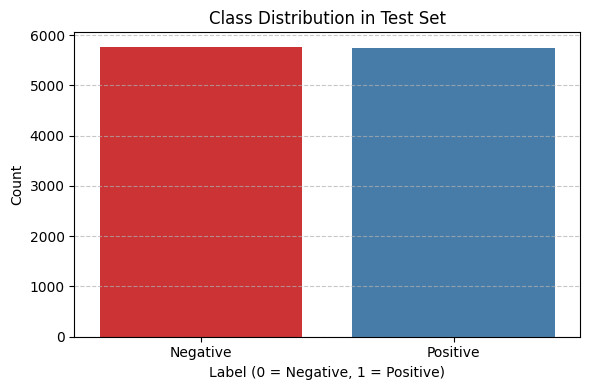

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=test_df, x='label', palette='Set1')
plt.title('Class Distribution in Test Set')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
train, valid = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['label'])

In [ ]:
# Check data sizes
print(f"Training set: {len(train)} samples")
print(f"Validation set: {len(valid)} samples")
print(f"Test set: {len(test_df)} samples")

# Build vocabulary from the training data
def build_vocab(texts, max_vocab_size=10000, min_freq=2):
    word_counts = Counter()
    # Count all words in the corpus
    print("Building vocabulary...")
    for text in texts:
        for word in text.split():
            word_counts[word] += 1

    print(f"Total unique words before filtering: {len(word_counts)}")

    # Filter words by frequency and cap by max_vocab_size
    vocab = {'<PAD>': 0, '<UNK>': 1}  # Special tokens
    vocab_idx = 2

    for word, count in word_counts.most_common(max_vocab_size - 2):  # -2 for special tokens
        if count >= min_freq:
            vocab[word] = vocab_idx
            vocab_idx += 1

    print(f"Vocabulary size after filtering: {len(vocab)}")
    return vocab

# Create vocabulary from training data
vocab = build_vocab(train['text'], max_vocab_size=20000, min_freq=2)
print(f"Vocabulary size: {len(vocab)}")

Training set: 38483 samples
Validation set: 6792 samples
Test set: 11520 samples
Building vocabulary...
Total unique words before filtering: 14660
Vocabulary size after filtering: 8849
Vocabulary size: 8849


In [ ]:
# Convert text to sequences of indices
def text_to_sequence(text, vocab, max_len=100):
    words = text.split()
    # Truncate if longer than max_len
    if len(words) > max_len:
        words = words[:max_len]

    indices = []
    for word in words:
        if word in vocab:
            indices.append(vocab[word])
        else:
            indices.append(vocab['<UNK>'])

    padding_length = max_len - len(indices)
    if padding_length > 0:
        indices = indices + [vocab['<PAD>']] * padding_length

    return indices

In [3]:
class ArabicSentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

        print("Pre-processing dataset...")
        self.sequences = []
        for idx in range(len(self.texts)):
            text = self.texts.iloc[idx]
            sequence = text_to_sequence(text, self.vocab, self.max_len)
            self.sequences.append(sequence)
        print(f"Dataset preprocessing complete. {len(self.sequences)} sequences created.")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        label = self.labels.iloc[idx]
        sequence = self.sequences[idx]

        return {
            'text': torch.tensor(sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.float)
        }

In [ ]:
# Set hyperparameters
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
N_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.6
MAX_LENGTH = 75
BATCH_SIZE = 128
LEARNING_RATE = 5e-4
EPOCHS = 25

# Create DataLoaders
train_dataset = ArabicSentimentDataset(train['text'], train['label'], vocab, MAX_LENGTH)
valid_dataset = ArabicSentimentDataset(valid['text'], valid['label'], vocab, MAX_LENGTH)
test_dataset = ArabicSentimentDataset(test_df['text'], test_df['label'], vocab, MAX_LENGTH)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Define LSTM model
class LSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, no_layers, hidden_dim, output_dim,
                 dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.4)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                            num_layers=no_layers,
                           bidirectional=True,
                           dropout=dropout,
                           batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )

    def forward(self, text):
        embedded = self.emb_dropout(self.embedding(text))
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.classifier(hidden)


# Set hyperparameters
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
LEARNING_RATE = 5e-5
EPOCHS = 100

# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print vocabulary stats to debug
print(f"Vocabulary size: {len(vocab)}")
print(f"Maximum index in vocabulary: {max(vocab.values())}")
print(f"PAD idx: {vocab['<PAD>']}, UNK idx: {vocab['<UNK>']}")

model = LSTMSentimentClassifier(
    vocab_size=len(vocab),
    no_layers=N_LAYERS,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=1,
    dropout=DROPOUT,
    pad_idx=vocab['<PAD>']
).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=True
)

Using device: cuda
Vocabulary size: 8849
Maximum index in vocabulary: 8848
PAD idx: 0, UNK idx: 1


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training function
def train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, scheduler, epochs):
    best_valid_loss = float('inf')
    patience = 5
    counter = 0

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.6f}")

        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            text = batch['text'].to(device)
            labels = batch['label'].float().to(device)  # Ensure labels are float for BCE

            optimizer.zero_grad()
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.round(torch.sigmoid(predictions))
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_dataloader)
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_total = 0

        with torch.no_grad():
            for batch in tqdm(valid_dataloader, desc="Validation"):
                text = batch['text'].to(device)
                labels = batch['label'].float().to(device)

                predictions = model(text).squeeze(1)
                loss = criterion(predictions, labels)

                valid_loss += loss.item()
                predicted = torch.round(torch.sigmoid(predictions))
                valid_correct += (predicted == labels).sum().item()
                valid_total += labels.size(0)

        valid_loss /= len(valid_dataloader)
        valid_acc = valid_correct / valid_total

        # Scheduler step
        scheduler.step(valid_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            counter = 0
            torch.save(model.state_dict(), 'best_arabic_sentiment_model.pt')
            print("✔ Saved best model")
        else:
            counter += 1
            print(f"No improvement for {counter} epochs")

        if counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    return history


# Evaluate on test set
def evaluate(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            # Get data
            text = batch['text'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            # Calculate accuracy
            test_loss += loss.item()
            predicted = torch.round(torch.sigmoid(predictions))
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Save predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_dataloader)
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return all_predictions, all_labels

In [ ]:
history = train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, scheduler, EPOCHS)

# Load best model
model.load_state_dict(torch.load('best_arabic_sentiment_model.pt'))

print(f"------------------------------\n")
# Evaluate on test set
predictions, labels = evaluate(model, test_dataloader, criterion)


Epoch 1/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 64.05it/s]


Train Loss: 0.6927 | Train Acc: 0.5170
Valid Loss: 0.6901 | Valid Acc: 0.5817
✔ Saved best model

Epoch 2/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.83it/s]


Train Loss: 0.6745 | Train Acc: 0.5831
Valid Loss: 0.6504 | Valid Acc: 0.6162
✔ Saved best model

Epoch 3/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.68it/s]


Train Loss: 0.6528 | Train Acc: 0.6088
Valid Loss: 0.6335 | Valid Acc: 0.6385
✔ Saved best model

Epoch 4/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.73it/s]


Train Loss: 0.6409 | Train Acc: 0.6238
Valid Loss: 0.6182 | Valid Acc: 0.6547
✔ Saved best model

Epoch 5/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.21it/s]


Train Loss: 0.6254 | Train Acc: 0.6438
Valid Loss: 0.6027 | Valid Acc: 0.6680
✔ Saved best model

Epoch 6/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 72.66it/s]


Train Loss: 0.6133 | Train Acc: 0.6522
Valid Loss: 0.5868 | Valid Acc: 0.6812
✔ Saved best model

Epoch 7/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.74it/s]


Train Loss: 0.6035 | Train Acc: 0.6626
Valid Loss: 0.5802 | Valid Acc: 0.6843
✔ Saved best model

Epoch 8/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.58it/s]


Train Loss: 0.5980 | Train Acc: 0.6661
Valid Loss: 0.5716 | Valid Acc: 0.6913
✔ Saved best model

Epoch 9/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.36it/s]


Train Loss: 0.5894 | Train Acc: 0.6753
Valid Loss: 0.5655 | Valid Acc: 0.6938
✔ Saved best model

Epoch 10/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.89it/s]


Train Loss: 0.5852 | Train Acc: 0.6776
Valid Loss: 0.5638 | Valid Acc: 0.6968
✔ Saved best model

Epoch 11/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.88it/s]


Train Loss: 0.5819 | Train Acc: 0.6810
Valid Loss: 0.5558 | Valid Acc: 0.7019
✔ Saved best model

Epoch 12/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.46it/s]


Train Loss: 0.5799 | Train Acc: 0.6800
Valid Loss: 0.5551 | Valid Acc: 0.6989
✔ Saved best model

Epoch 13/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.65it/s]


Train Loss: 0.5727 | Train Acc: 0.6859
Valid Loss: 0.5509 | Valid Acc: 0.6999
✔ Saved best model

Epoch 14/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 67.60it/s]


Train Loss: 0.5701 | Train Acc: 0.6910
Valid Loss: 0.5470 | Valid Acc: 0.7048
✔ Saved best model

Epoch 15/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 64.27it/s]


Train Loss: 0.5678 | Train Acc: 0.6922
Valid Loss: 0.5432 | Valid Acc: 0.7119
✔ Saved best model

Epoch 16/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.68it/s]


Train Loss: 0.5640 | Train Acc: 0.6949
Valid Loss: 0.5411 | Valid Acc: 0.7070
✔ Saved best model

Epoch 17/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.13it/s]


Train Loss: 0.5586 | Train Acc: 0.7002
Valid Loss: 0.5371 | Valid Acc: 0.7126
✔ Saved best model

Epoch 18/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.93it/s]


Train Loss: 0.5587 | Train Acc: 0.7017
Valid Loss: 0.5337 | Valid Acc: 0.7147
✔ Saved best model

Epoch 19/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.23it/s]


Train Loss: 0.5535 | Train Acc: 0.7066
Valid Loss: 0.5311 | Valid Acc: 0.7157
✔ Saved best model

Epoch 20/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.06it/s]


Train Loss: 0.5509 | Train Acc: 0.7069
Valid Loss: 0.5285 | Valid Acc: 0.7179
✔ Saved best model

Epoch 21/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 65.67it/s]


Train Loss: 0.5486 | Train Acc: 0.7077
Valid Loss: 0.5287 | Valid Acc: 0.7173
No improvement for 1 epochs

Epoch 22/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.70it/s]


Train Loss: 0.5481 | Train Acc: 0.7089
Valid Loss: 0.5234 | Valid Acc: 0.7216
✔ Saved best model

Epoch 23/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.74it/s]


Train Loss: 0.5452 | Train Acc: 0.7087
Valid Loss: 0.5226 | Valid Acc: 0.7201
✔ Saved best model

Epoch 24/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.93it/s]


Train Loss: 0.5392 | Train Acc: 0.7156
Valid Loss: 0.5214 | Valid Acc: 0.7226
✔ Saved best model

Epoch 25/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.16it/s]


Train Loss: 0.5390 | Train Acc: 0.7149
Valid Loss: 0.5191 | Valid Acc: 0.7261
✔ Saved best model

Epoch 26/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.62it/s]


Train Loss: 0.5362 | Train Acc: 0.7160
Valid Loss: 0.5168 | Valid Acc: 0.7292
✔ Saved best model

Epoch 27/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.59it/s]


Train Loss: 0.5340 | Train Acc: 0.7194
Valid Loss: 0.5149 | Valid Acc: 0.7261
✔ Saved best model

Epoch 28/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.50it/s]


Train Loss: 0.5331 | Train Acc: 0.7223
Valid Loss: 0.5153 | Valid Acc: 0.7260
No improvement for 1 epochs

Epoch 29/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.99it/s]


Train Loss: 0.5312 | Train Acc: 0.7219
Valid Loss: 0.5211 | Valid Acc: 0.7191
No improvement for 2 epochs

Epoch 30/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.09it/s]


Train Loss: 0.5273 | Train Acc: 0.7214
Valid Loss: 0.5103 | Valid Acc: 0.7301
✔ Saved best model

Epoch 31/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.71it/s]


Train Loss: 0.5262 | Train Acc: 0.7253
Valid Loss: 0.5127 | Valid Acc: 0.7281
No improvement for 1 epochs

Epoch 32/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.74it/s]


Train Loss: 0.5213 | Train Acc: 0.7292
Valid Loss: 0.5082 | Valid Acc: 0.7307
✔ Saved best model

Epoch 33/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.25it/s]


Train Loss: 0.5221 | Train Acc: 0.7274
Valid Loss: 0.5133 | Valid Acc: 0.7272
No improvement for 1 epochs

Epoch 34/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.43it/s]


Train Loss: 0.5179 | Train Acc: 0.7306
Valid Loss: 0.5038 | Valid Acc: 0.7363
✔ Saved best model

Epoch 35/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.20it/s]


Train Loss: 0.5193 | Train Acc: 0.7273
Valid Loss: 0.5038 | Valid Acc: 0.7359
No improvement for 1 epochs

Epoch 36/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 64.18it/s]


Train Loss: 0.5146 | Train Acc: 0.7336
Valid Loss: 0.5059 | Valid Acc: 0.7340
No improvement for 2 epochs

Epoch 37/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.13it/s]


Train Loss: 0.5184 | Train Acc: 0.7303
Valid Loss: 0.5037 | Valid Acc: 0.7348
✔ Saved best model

Epoch 38/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.06it/s]


Train Loss: 0.5135 | Train Acc: 0.7346
Valid Loss: 0.4997 | Valid Acc: 0.7379
✔ Saved best model

Epoch 39/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.04it/s]


Train Loss: 0.5146 | Train Acc: 0.7358
Valid Loss: 0.5004 | Valid Acc: 0.7381
No improvement for 1 epochs

Epoch 40/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.44it/s]


Train Loss: 0.5077 | Train Acc: 0.7379
Valid Loss: 0.5000 | Valid Acc: 0.7394
No improvement for 2 epochs

Epoch 41/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.38it/s]


Train Loss: 0.5078 | Train Acc: 0.7419
Valid Loss: 0.4969 | Valid Acc: 0.7413
✔ Saved best model

Epoch 42/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.62it/s]


Train Loss: 0.5040 | Train Acc: 0.7388
Valid Loss: 0.4943 | Valid Acc: 0.7415
✔ Saved best model

Epoch 43/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.44it/s]


Train Loss: 0.5064 | Train Acc: 0.7390
Valid Loss: 0.5001 | Valid Acc: 0.7359
No improvement for 1 epochs

Epoch 44/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.63it/s]


Train Loss: 0.4999 | Train Acc: 0.7429
Valid Loss: 0.4936 | Valid Acc: 0.7435
✔ Saved best model

Epoch 45/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.40it/s]


Train Loss: 0.5010 | Train Acc: 0.7432
Valid Loss: 0.4930 | Valid Acc: 0.7415
✔ Saved best model

Epoch 46/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.48it/s]


Train Loss: 0.5012 | Train Acc: 0.7435
Valid Loss: 0.4907 | Valid Acc: 0.7448
✔ Saved best model

Epoch 47/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.28it/s]


Train Loss: 0.4982 | Train Acc: 0.7441
Valid Loss: 0.4984 | Valid Acc: 0.7437
No improvement for 1 epochs

Epoch 48/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.75it/s]


Train Loss: 0.4984 | Train Acc: 0.7449
Valid Loss: 0.4928 | Valid Acc: 0.7426
No improvement for 2 epochs

Epoch 49/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.83it/s]


Train Loss: 0.4925 | Train Acc: 0.7467
Valid Loss: 0.4893 | Valid Acc: 0.7418
✔ Saved best model

Epoch 50/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.73it/s]


Train Loss: 0.4923 | Train Acc: 0.7479
Valid Loss: 0.4998 | Valid Acc: 0.7412
No improvement for 1 epochs

Epoch 51/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.43it/s]


Train Loss: 0.4933 | Train Acc: 0.7505
Valid Loss: 0.4919 | Valid Acc: 0.7418
No improvement for 2 epochs

Epoch 52/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.43it/s]


Train Loss: 0.4894 | Train Acc: 0.7498
Valid Loss: 0.4856 | Valid Acc: 0.7460
✔ Saved best model

Epoch 53/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.11it/s]


Train Loss: 0.4897 | Train Acc: 0.7506
Valid Loss: 0.4843 | Valid Acc: 0.7493
✔ Saved best model

Epoch 54/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.50it/s]


Train Loss: 0.4878 | Train Acc: 0.7519
Valid Loss: 0.4845 | Valid Acc: 0.7476
No improvement for 1 epochs

Epoch 55/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.68it/s]


Train Loss: 0.4836 | Train Acc: 0.7558
Valid Loss: 0.4845 | Valid Acc: 0.7469
No improvement for 2 epochs

Epoch 56/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.13it/s]


Train Loss: 0.4811 | Train Acc: 0.7564
Valid Loss: 0.4842 | Valid Acc: 0.7473
✔ Saved best model

Epoch 57/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 65.53it/s]


Train Loss: 0.4840 | Train Acc: 0.7522
Valid Loss: 0.4891 | Valid Acc: 0.7471
No improvement for 1 epochs

Epoch 58/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.31it/s]


Train Loss: 0.4807 | Train Acc: 0.7571
Valid Loss: 0.4812 | Valid Acc: 0.7500
✔ Saved best model

Epoch 59/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.14it/s]


Train Loss: 0.4791 | Train Acc: 0.7580
Valid Loss: 0.4857 | Valid Acc: 0.7529
No improvement for 1 epochs

Epoch 60/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.88it/s]


Train Loss: 0.4799 | Train Acc: 0.7597
Valid Loss: 0.4807 | Valid Acc: 0.7506
✔ Saved best model

Epoch 61/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.58it/s]


Train Loss: 0.4755 | Train Acc: 0.7584
Valid Loss: 0.4808 | Valid Acc: 0.7499
No improvement for 1 epochs

Epoch 62/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.10it/s]


Train Loss: 0.4751 | Train Acc: 0.7593
Valid Loss: 0.4793 | Valid Acc: 0.7499
✔ Saved best model

Epoch 63/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 61.89it/s]


Train Loss: 0.4734 | Train Acc: 0.7616
Valid Loss: 0.4817 | Valid Acc: 0.7494
No improvement for 1 epochs

Epoch 64/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.81it/s]


Train Loss: 0.4757 | Train Acc: 0.7621
Valid Loss: 0.4797 | Valid Acc: 0.7529
No improvement for 2 epochs

Epoch 65/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.98it/s]


Train Loss: 0.4728 | Train Acc: 0.7623
Valid Loss: 0.4769 | Valid Acc: 0.7515
✔ Saved best model

Epoch 66/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.21it/s]


Train Loss: 0.4719 | Train Acc: 0.7630
Valid Loss: 0.4779 | Valid Acc: 0.7518
No improvement for 1 epochs

Epoch 67/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.62it/s]


Train Loss: 0.4700 | Train Acc: 0.7642
Valid Loss: 0.4757 | Valid Acc: 0.7556
✔ Saved best model

Epoch 68/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.43it/s]


Train Loss: 0.4696 | Train Acc: 0.7641
Valid Loss: 0.4773 | Valid Acc: 0.7510
No improvement for 1 epochs

Epoch 69/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.30it/s]


Train Loss: 0.4642 | Train Acc: 0.7682
Valid Loss: 0.4787 | Valid Acc: 0.7524
No improvement for 2 epochs

Epoch 70/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.55it/s]


Train Loss: 0.4670 | Train Acc: 0.7669
Valid Loss: 0.4754 | Valid Acc: 0.7568
✔ Saved best model

Epoch 71/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.55it/s]


Train Loss: 0.4652 | Train Acc: 0.7656
Valid Loss: 0.4799 | Valid Acc: 0.7522
No improvement for 1 epochs

Epoch 72/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 71.16it/s]


Train Loss: 0.4638 | Train Acc: 0.7677
Valid Loss: 0.4770 | Valid Acc: 0.7543
No improvement for 2 epochs

Epoch 73/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.14it/s]


Train Loss: 0.4616 | Train Acc: 0.7700
Valid Loss: 0.4731 | Valid Acc: 0.7549
✔ Saved best model

Epoch 74/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.96it/s]


Train Loss: 0.4617 | Train Acc: 0.7683
Valid Loss: 0.4740 | Valid Acc: 0.7538
No improvement for 1 epochs

Epoch 75/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.58it/s]


Train Loss: 0.4599 | Train Acc: 0.7710
Valid Loss: 0.4745 | Valid Acc: 0.7550
No improvement for 2 epochs

Epoch 76/100
Learning Rate: 0.000050


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.28it/s]


Train Loss: 0.4563 | Train Acc: 0.7746
Valid Loss: 0.4767 | Valid Acc: 0.7585
No improvement for 3 epochs

Epoch 77/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.95it/s]


Train Loss: 0.4539 | Train Acc: 0.7754
Valid Loss: 0.4723 | Valid Acc: 0.7578
✔ Saved best model

Epoch 78/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.50it/s]


Train Loss: 0.4539 | Train Acc: 0.7737
Valid Loss: 0.4719 | Valid Acc: 0.7574
✔ Saved best model

Epoch 79/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.78it/s]


Train Loss: 0.4545 | Train Acc: 0.7783
Valid Loss: 0.4715 | Valid Acc: 0.7572
✔ Saved best model

Epoch 80/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.39it/s]


Train Loss: 0.4539 | Train Acc: 0.7731
Valid Loss: 0.4720 | Valid Acc: 0.7569
No improvement for 1 epochs

Epoch 81/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.91it/s]


Train Loss: 0.4521 | Train Acc: 0.7751
Valid Loss: 0.4721 | Valid Acc: 0.7572
No improvement for 2 epochs

Epoch 82/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.74it/s]


Train Loss: 0.4536 | Train Acc: 0.7763
Valid Loss: 0.4713 | Valid Acc: 0.7584
✔ Saved best model

Epoch 83/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.95it/s]


Train Loss: 0.4512 | Train Acc: 0.7753
Valid Loss: 0.4726 | Valid Acc: 0.7568
No improvement for 1 epochs

Epoch 84/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 63.22it/s]


Train Loss: 0.4526 | Train Acc: 0.7751
Valid Loss: 0.4711 | Valid Acc: 0.7574
✔ Saved best model

Epoch 85/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 64.28it/s]


Train Loss: 0.4511 | Train Acc: 0.7764
Valid Loss: 0.4720 | Valid Acc: 0.7566
No improvement for 1 epochs

Epoch 86/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.74it/s]


Train Loss: 0.4495 | Train Acc: 0.7766
Valid Loss: 0.4711 | Valid Acc: 0.7575
✔ Saved best model

Epoch 87/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.74it/s]


Train Loss: 0.4556 | Train Acc: 0.7724
Valid Loss: 0.4719 | Valid Acc: 0.7568
No improvement for 1 epochs

Epoch 88/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.67it/s]


Train Loss: 0.4511 | Train Acc: 0.7766
Valid Loss: 0.4719 | Valid Acc: 0.7572
No improvement for 2 epochs

Epoch 89/100
Learning Rate: 0.000005


Validation: 100%|██████████| 54/54 [00:00<00:00, 70.04it/s]


Train Loss: 0.4514 | Train Acc: 0.7758
Valid Loss: 0.4718 | Valid Acc: 0.7560
No improvement for 3 epochs

Epoch 90/100
Learning Rate: 0.000001


Validation: 100%|██████████| 54/54 [00:00<00:00, 69.54it/s]


Train Loss: 0.4505 | Train Acc: 0.7749
Valid Loss: 0.4715 | Valid Acc: 0.7562
No improvement for 4 epochs

Epoch 91/100
Learning Rate: 0.000001


Validation: 100%|██████████| 54/54 [00:00<00:00, 62.50it/s]


Train Loss: 0.4494 | Train Acc: 0.7770
Valid Loss: 0.4714 | Valid Acc: 0.7566
No improvement for 5 epochs
Early stopping after 91 epochs
------------------------------



Testing: 100%|██████████| 90/90 [00:01<00:00, 66.15it/s]

Test Loss: 0.4724, Test Acc: 0.7630


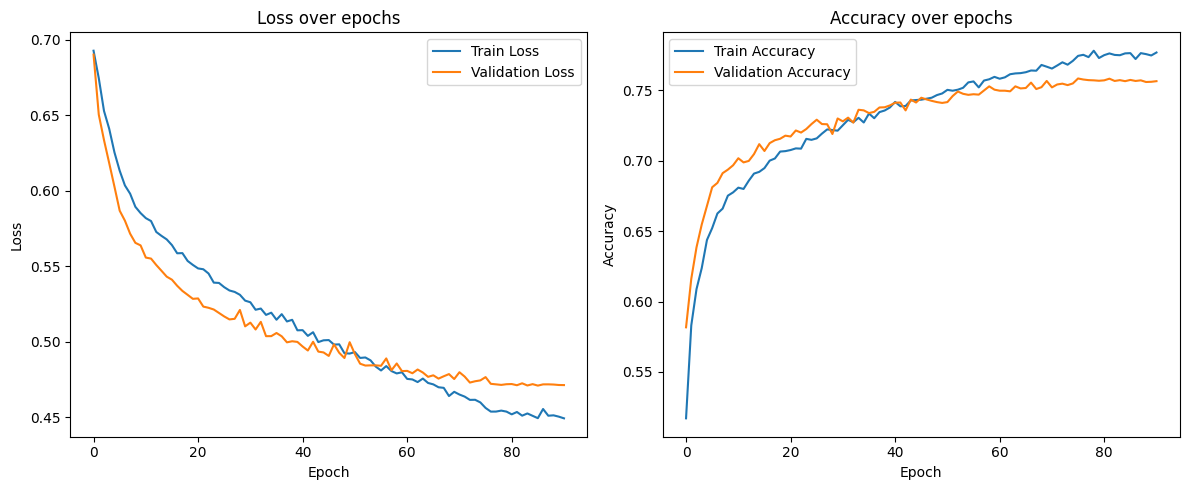

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      5768
         1.0       0.79      0.71      0.75      5752

    accuracy                           0.76     11520
   macro avg       0.77      0.76      0.76     11520
weighted avg       0.77      0.76      0.76     11520



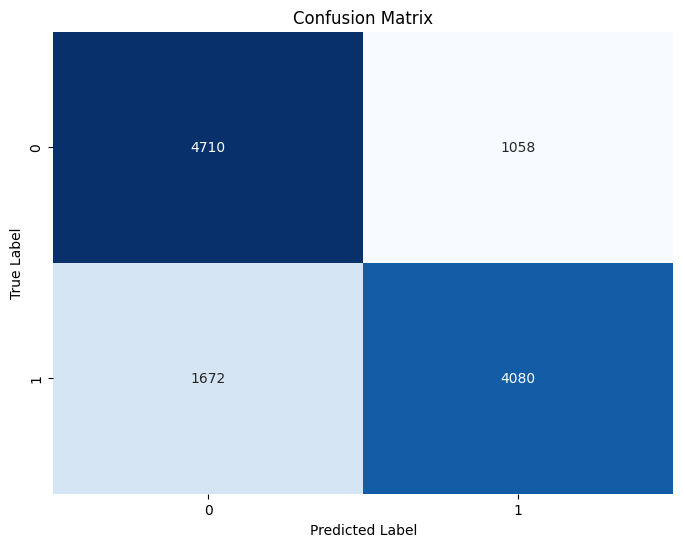

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.tight_layout()
plt.show()


# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Plot a confusion matrix for the given true and predicted labels."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Print classification report
print(classification_report(labels, predictions))

# Plot confusion matrix
plot_confusion_matrix(labels, predictions)

In [ ]:
# Example of using the trained model for sentiment prediction
def predict_sentiment(text, model, vocab):
    model.eval()

    # Clean and preprocess text
    clean = clean_text(text)

    # Convert to sequence
    sequence = text_to_sequence(clean, vocab, MAX_LENGTH)

    # Convert to tensor
    tensor = torch.tensor(sequence).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))

    sentiment = "Positive" if prediction.item() >= 0.5 else "Negative"

    return sentiment

# Test with some examples
example_texts = [
    "برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع",
    "هذا الفيلم سيء للغاية"\
]

for text in example_texts:
    sentiment = predict_sentiment(text, model, vocab)
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}")
    print("-" * 50)

Text: برنامج رائع جدا يساعد على تلبيه الاحتياجات بشكل اسرع
Sentiment: Positive
--------------------------------------------------
Text: هذا الفيلم سيء للغاية
Sentiment: Negative
--------------------------------------------------
